# 3. Clustering
- Word2Vec
- greedy_modularity_communities 클러스터 수행

## 1. Word2Vec

In [1]:
# Library
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from konlpy.tag import Okt

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [4]:
preprocess_data = pd.read_csv('./Data/Preprocess_Data/최종추출본.csv')

In [5]:
# 연도 가져오기
preprocess_data.head()

,list,year
0,"a, method, peer_to_peer_streaming, video_on_de...",2013
1,"in, paper, information_processing, designing, ...",2013
2,"a, digital_humanity, work, in, goal, is, a, a,...",2013
3,"work, step, nano, scale, reservoir_computing, ...",2013
4,"goal, extraction, in, learning_by_demonstratio...",2013


In [6]:
# 정규표현식을 사용하여 's와 영어 알파벳, 숫자, 그리고 underscore('_') 이외의 문자 제거
preprocess_data['list'] = preprocess_data['list'].astype(str)
preprocess_data['list'] = preprocess_data['list'].apply(lambda x: re.sub(r"[^a-zA-Z0-9_\s]|'s\b", '', x))

In [7]:
# 공백이 2칸 이상이면 한칸으로 줄어듦
preprocess_data['list'] = preprocess_data['list'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))

In [8]:
preprocess_data['list'][10]

'paper use in application competitive coevolution strategy in a player real_time_strategy_game in university research purpose goal is testing approach in order concept a part in competitive coevolutionary_algorithm approach difference implementation a a or short_term_memory mechanism police in memory updating process individual in order robust in evaluation phase it is strategy update set basis quality diversity result'

### 불용어 제거하고 Word2Vec

In [23]:
import logging
preprocess_data['list'] = preprocess_data['list'].astype(str)

# 불용어 설정
stop_words = set(stopwords.words('english'))

# 텍스트 데이터 전처리 및 토큰화, 불용어 제거
preprocess_data['tokens'] = preprocess_data['list'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])


In [44]:
preprocess_data['tokens'][0]

'method peer_to_peer_streaming video_on_demand node problem peer_to_peer video_on_demand streaming disk user content malicious_user content method ha advantage user disk version content version disk peer_to_peer scheme content distribution ieee'

## 2. 각 키워드별 연도 삽입

In [24]:
preprocess_data['tokens'] = preprocess_data['tokens'].apply(lambda x: ' '.join(x))

In [26]:
# token 따로 저장
token_df = preprocess_data[['tokens','year']]
token_df.to_csv('Data/Preprocess_Data/word_token.csv', index=False, encoding='utf-8-sig')

In [27]:
t = token_df.copy()

In [28]:
# year 칼럼의 뒤의 두 자리 추출
t['year_suffix'] = t['year'].astype(str).str[-2:]
# list 칼럼의 단어들을 분리하여 리스트로 변환
word_lists = t['tokens'].str.split()

In [29]:
word_lists

0          [method, peer_to_peer_streaming, video_on_dema...
1          [paper, information_processing, designing, rou...
2          [digital_humanity, work, goal, domain, time, d...
3          [work, step, nano, scale, reservoir_computing,...
4          [goal, extraction, learning_by_demonstration, ...
                                 ...                        
2267158    [human_centered, development, information_syst...
2267159    [computing, device, cloud, fog, data_center, c...
2267160    [mobile_technology, pedagogical_tool, higher_e...
2267161    [development, intelligent_system, pursuit, det...
2267162    [paper, utility, purpose, open, domain, semant...
Name: tokens, Length: 2267163, dtype: object

In [32]:
new_word_lists = []
for words, suffix in tqdm(zip(word_lists, t['year_suffix']), total=len(t)):
    new_words = [str(suffix) + '_' + word for word in words]
    new_word_lists.append(new_words)

100%|██████████████████████████████| 2267163/2267163 [02:27<00:00, 15377.20it/s]


In [33]:
# 리스트를 하나의 문자열로 변환하여 list 칼럼에 덮어씌움
t['tokens'] = pd.Series([' '.join(words) for words in tqdm(new_word_lists)])

# year_suffix 칼럼 제거
t = t.drop('year_suffix', axis=1)


100%|█████████████████████████████| 2267163/2267163 [00:08<00:00, 273368.85it/s]


In [34]:
t.head()

,tokens,year
0,13_method 13_peer_to_peer_streaming 13_video_o...,2013
1,13_paper 13_information_processing 13_designin...,2013
2,13_digital_humanity 13_work 13_goal 13_domain ...,2013
3,13_work 13_step 13_nano 13_scale 13_reservoir_...,2013
4,13_goal 13_extraction 13_learning_by_demonstra...,2013


In [35]:
t.to_csv('Data/Preprocess_Data/word_token+year.csv', encoding='utf-8-sig', index=False)

In [76]:
t['tokens'][10]

'13_paper 13_use 13_application 13_competitive 13_coevolution 13_strategy 13_player 13_real_time_strategy_game 13_university 13_research 13_purpose 13_goal 13_testing 13_approach 13_order 13_concept 13_part 13_competitive 13_coevolutionary_algorithm 13_approach 13_difference 13_implementation 13_short_term_memory 13_mechanism 13_police 13_memory 13_updating 13_process 13_individual 13_order 13_robust 13_evaluation 13_phase 13_strategy 13_update 13_set 13_basis 13_quality 13_diversity 13_result'

In [50]:
words = pd.read_csv('./Data/Preprocess_Data/up20_words.csv')

In [58]:
words[words['word']=='problem']

,word,count
6532,problem,119


### 연도 집어넣은 것을 바탕으로 word2vec 시행

In [2]:
t = pd.read_csv('./Data/Preprocess_Data/word_token+year.csv')

In [3]:
t2 = t[t['year']>=2021]

In [4]:
t2.head()

,tokens,year
244283,22_potential 22_automation 22_selection 22_tas...,2022
244284,22_contribution 22_part 22_study 22_cultural_h...,2022
244285,22_focus 22_characterization 22_metrology 22_o...,2022
244286,22_study 22_focus 22_characterization 22_fusio...,2022
244287,22_study 22_aim 22_predicting 22_outcome 22_le...,2022


In [5]:
t2.reset_index(drop=True, inplace=True)

In [6]:
# 샘플 워드투벡 (21,22,23년도) - 디버깅
t2['tokens2'] = t2['tokens'].apply(lambda x: [word for word in word_tokenize(x)])
sentences = t2['tokens2'].tolist()
# Word2Vec 모델 학습
model = Word2Vec(sentences, min_count=1)

# 단어 벡터 확인
word_vectors = model.wv

In [60]:
similar_words = model.wv.most_similar('22_machine_learning', topn=30)
print(similar_words)

[('22_machine_learning_technique', 0.8554499745368958), ('22_artificial_intelligence_technique', 0.8158286809921265), ('22_machine_learning_algorithm', 0.8083047866821289), ('22_machine_learning_method', 0.8065057992935181), ('22_machine_learning_approach', 0.792664110660553), ('22_deep_learning', 0.7711058855056763), ('22_data_mining', 0.7665949463844299), ('22_predictive_analytics', 0.7609307765960693), ('22_artificial_intelligence_algorithm', 0.7608203291893005), ('22_supervised_machine_learning', 0.7326877117156982), ('22_machine_learning_model', 0.7318495512008667), ('22_artificial_intelligence', 0.7248015999794006), ('22_data_science', 0.7244879603385925), ('22_data_mining_technique', 0.7239727973937988), ('22_ml_algorithm', 0.7210749387741089), ('22_machine_learning_application', 0.7167448997497559), ('22_deep_learning_algorithm', 0.7152817249298096), ('22_deep_learning_technique', 0.7078437209129333), ('22_pattern_recognition', 0.7012099623680115), ('22_data_mining_algorithm', 

In [67]:
model.wv.similarity('22_feature_engineering', '23_feature_engineering')

0.2816874

In [68]:
model.wv.similarity('21_feature_engineering', '22_feature_engineering')

-0.06740075

In [64]:
model.wv.similarity('21_machine_learning', '23_machine_learning')

0.013124725

In [7]:
# 모델 저장
model.save('212223_word2vec.model')

In [8]:
# 단어 벡터 저장
word_vectors = model.wv
word_vectors.save("212223_word_vectors.kv")

- 메인 코드

In [18]:
# 텍스트 데이터 전처리 및 토큰화, 불용어 제거
t['tokens2'] = t['tokens'].apply(lambda x: [word for word in word_tokenize(x)])
sentences = t['tokens2'].tolist()
# Word2Vec 모델 학습
model = Word2Vec(sentences, min_count=1)

# 단어 벡터 확인
word_vectors = model.wv

In [29]:
sentences

[['13_method',
  '13_peer_to_peer_streaming',
  '13_video_on_demand_with',
  '13_residential',
  '13_node',
  '13_described',
  '13_possible',
  '13_problem',
  '13_peer_to_peer_video_on_demand_streaming',
  '13_necessity',
  '13_storing',
  '13_disk',
  '13_residential',
  '13_user',
  '13_content',
  '13_streamed',
  '13_allowing',
  '13_malicious_user',
  '13_distribute',
  '13_illegally',
  '13_content',
  '13_proposed',
  '13_method',
  '13_ha',
  '13_advantage',
  '13_storing',
  '13_users',
  '13_disk',
  '13_reduced',
  '13_version',
  '13_content',
  '13_although',
  '13_reduced',
  '13_version',
  '13_stored',
  '13_disk',
  '13_still',
  '13_used',
  '13_proposed',
  '13_peer_to_peer_scheme',
  '13_sufficient',
  '13_recover',
  '13_original',
  '13_content',
  '13_preventing',
  '13_unauthorized',
  '13_distribution',
  '13_2013',
  '13_ieee'],
 ['13_paper',
  '13_discus',
  '13_bacterial',
  '13_network_communication_design',
  '13_respect',
  '13_metabolic',
  '13_informa

In [20]:
# 모델 저장
model.save('Data/Preprocess_Data/year_word2vec.model')

In [19]:
# 단어 벡터 저장
word_vectors = model.wv
word_vectors.save("Data/Preprocess_Data/year_word_vectors.kv")

In [27]:
similar_words = model.wv.most_similar('20_deep_learning', topn=30)
print(similar_words)

[('20_deep_learning_such', 0.9240278005599976), ('20_face_tracking', 0.922843337059021), ('20_self_calibration', 0.9179024696350098), ('20_batch_processing', 0.916452169418335), ('20_quantum_annealing', 0.9142048954963684), ('20_sw', 0.9131624698638916), ('20_tasnet', 0.9126613736152649), ('20_parallel_structure', 0.9123446345329285), ('20_biped', 0.9123086333274841), ('20_tsv', 0.9116710424423218), ('20_broadens', 0.9115983843803406), ('20_matrix_profile', 0.9092435240745544), ('20_duo', 0.9091187119483948), ('20_coral', 0.9090192317962646), ('20_semantic_slam', 0.9086829423904419), ('20_pea', 0.9064937233924866), ('20_graphic_processing_unit_in', 0.9060552716255188), ('20_hierarchal', 0.9059861302375793), ('20_defect_prediction', 0.9052213430404663), ('20_supercomputing_system', 0.9050830602645874), ('20_convolutional_neural_network_used', 0.9048026204109192), ('20_system_form', 0.903627872467041), ('20_deep_learning_on', 0.9034767150878906), ('20_tmp', 0.9033932089805603), ('20_qsm'

In [37]:
similar_words = model.wv.most_similar('21_deep_learning', topn=30)
print(similar_words)

[('21_unsupervised_clustering', 0.9521017074584961), ('21_deep_learning_neural_network', 0.9518150687217712), ('21_cnn_a', 0.9493940472602844), ('21_supervised_machine_learning', 0.9444615244865417), ('21_convolutional_neural_network_a', 0.9442992806434631), ('21_sensor_fusion', 0.9433633685112), ('21_plant_disease_detection', 0.9391286373138428), ('21_fr', 0.9386753439903259), ('21_deep_learning_with', 0.9383673667907715), ('21_computer_vision_algorithm', 0.93697190284729), ('21_machine_learning_the', 0.9366346001625061), ('21_hyperparameter_optimization', 0.9346891641616821), ('21_text_recognition', 0.9329452514648438), ('21_lbg', 0.9310063719749451), ('21_statistical_approach', 0.9305200576782227), ('21_cntfet', 0.9302946925163269), ('21_bc', 0.9297635555267334), ('21_dt', 0.9288817644119263), ('21_data_mining_algorithm', 0.9272863864898682), ('21_time_series_model', 0.9272447228431702), ('21_cyberattack_detection', 0.9268218278884888), ('21_da', 0.9268202781677246), ('21_apriori_al

In [38]:
model.wv.similarity('13_machine_learning', '14_machine_learning')

0.4937513

In [24]:
# 2020년 데이터만
t_2020 = t[t['year']==2020]
t_2020.reset_index(drop=True, inplace=True)

In [86]:
t2

,tokens,year,tokens2
0,22_potential 22_automation 22_selection 22_tas...,2022,"[22_potential, 22_automation, 22_selection, 22..."
1,22_contribution 22_part 22_study 22_cultural_h...,2022,"[22_contribution, 22_part, 22_study, 22_cultur..."
2,22_focus 22_characterization 22_metrology 22_o...,2022,"[22_focus, 22_characterization, 22_metrology, ..."
3,22_study 22_focus 22_characterization 22_fusio...,2022,"[22_study, 22_focus, 22_characterization, 22_f..."
4,22_study 22_aim 22_predicting 22_outcome 22_le...,2022,"[22_study, 22_aim, 22_predicting, 22_outcome, ..."
...,...,...,...
338311,21_human_centered 21_development 21_informatio...,2021,"[21_human_centered, 21_development, 21_informa..."
338312,21_computing 21_device 21_cloud 21_fog 21_data...,2021,"[21_computing, 21_device, 21_cloud, 21_fog, 21..."
338313,21_mobile_technology 21_pedagogical_tool 21_hi...,2021,"[21_mobile_technology, 21_pedagogical_tool, 21..."
338314,21_development 21_intelligent_system 21_pursui...,2021,"[21_development, 21_intelligent_system, 21_pur..."


In [9]:
t2_2023 = t[t['year']==2023]
t2_2023.reset_index(drop=True, inplace=True)

In [10]:
t2_2023

,tokens,year
0,23_instrument 23_predict 23_future 23_weather ...,2023
1,23_virtual_museum 23_artifact 23_interactive 2...,2023
2,23_processing 23_data 23_accessible 23_edge_de...,2023
3,23_seismic 23_p 23_wave 23_picking 23_critical...,2023
4,23_research 23_ha 23_spatial_perception 23_abi...,2023
...,...,...
36153,23_network_model 23_fit 23_datasets 23_deep_le...,2023
36154,23_idea 23_hyperdimensional_computing 23_field...,2023
36155,23_recommendation_system 23_item 23_independen...,2023
36156,23_satellite_remote_sensing 23_image 23_proble...,2023


In [11]:
# 텍스트 데이터 전처리 및 토큰화
t2_2023['tokens2'] = t2_2023['tokens'].astype(str).apply(lambda x: word_tokenize(x))
t2_2023['tokens2'] = t2_2023['tokens2'].apply(lambda tokens: [token for token in tokens if token != ','])

In [12]:
sentences = t2_2023['tokens2'].tolist()
sentences = [sentence for sentence in tqdm(sentences, desc="Processing sentences")]

Processing sentences: 100%|██████████| 36158/36158 [00:00<00:00, 3680564.11it/s]


In [13]:
sentences_flat = [word for sentence in sentences for word in sentence]

In [14]:
len(sentences_flat)

2003687

In [15]:
sentences_flat = list(set(sentences_flat))

In [16]:
len(sentences_flat)

28242

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
# 주어진 단어들에 대한 Word2Vec 결과 벡터 추출
word_vecs = [word_vectors[word] for word in sentences_flat]

In [18]:
# 모든 단어 쌍의 코사인 유사도 계산
similarity_matrix = cosine_similarity(word_vecs)

# 대각선을 0으로 설정
np.fill_diagonal(similarity_matrix, 0)


# 결과를 DataFrame으로 변환
similarity_df = pd.DataFrame(similarity_matrix, index=sentences_flat, columns=sentences_flat)

In [19]:
similarity_df

,23_speech_recognition,23_spectral_radius,23_io,23_security_enhancement,23_kronecker_product,23_it_governance,23_syntactic_feature,23_misconception,23_admissibility,23_advanced_manufacturing,...,23_linear_quadratic_regulator,23_knowledge_gap,23_fmri,23_contact_center,23_ecosystem,23_indian_language,23_real_option,23_it_security,23_multi_view_image,23_data_scarcity
23_speech_recognition,0.000000,0.328814,0.683887,0.775956,0.322549,0.707735,0.728887,0.707267,0.358966,0.143038,...,0.639168,0.754503,0.800995,0.567724,0.583670,0.862690,0.718735,0.690741,0.850505,0.735337
23_spectral_radius,0.328814,0.000000,0.516074,0.479134,-0.068042,0.482426,0.547732,0.386136,0.493021,0.350890,...,0.522460,0.303540,0.549810,0.433186,0.476483,0.233378,0.496958,0.495792,0.513523,0.176987
23_io,0.683887,0.516074,0.000000,0.879854,0.032013,0.740912,0.654774,0.676909,0.727122,0.143705,...,0.710149,0.568541,0.718765,0.711356,0.805019,0.600473,0.781065,0.859819,0.724259,0.613900
23_security_enhancement,0.775956,0.479134,0.879854,0.000000,0.203911,0.825715,0.666849,0.599618,0.560666,0.241769,...,0.619701,0.608504,0.717123,0.568784,0.783999,0.573825,0.785180,0.900192,0.766521,0.685100
23_kronecker_product,0.322549,-0.068042,0.032013,0.203911,0.000000,0.245086,0.131252,0.120615,-0.151955,0.008322,...,0.171966,0.294799,0.165569,-0.033786,-0.058363,0.221127,0.175130,0.138388,0.301546,0.345178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23_indian_language,0.862690,0.233378,0.600473,0.573825,0.221127,0.528781,0.678196,0.811861,0.375967,-0.034114,...,0.610161,0.769262,0.782572,0.547442,0.490987,0.000000,0.678640,0.575773,0.758442,0.729716
23_real_option,0.718735,0.496958,0.781065,0.785180,0.175130,0.694845,0.585991,0.771971,0.584386,0.066595,...,0.665506,0.718730,0.766996,0.554618,0.712636,0.678640,0.000000,0.809070,0.737794,0.744624
23_it_security,0.690741,0.495792,0.859819,0.900192,0.138388,0.837552,0.626613,0.665268,0.499058,0.271862,...,0.610895,0.723284,0.650167,0.588513,0.861996,0.575773,0.809070,0.000000,0.648975,0.698062
23_multi_view_image,0.850505,0.513523,0.724259,0.766521,0.301546,0.756396,0.826901,0.713384,0.541326,0.198233,...,0.772526,0.650491,0.847871,0.652724,0.558541,0.758442,0.737794,0.648975,0.000000,0.646224


In [24]:
threshold = 0.75

above_threshold = np.sum(similarity_matrix >= threshold)
total_elements = np.prod(similarity_matrix.shape)
ratio = above_threshold / total_elements

print(f"Ratio above threshold ({threshold}): {ratio}")

Ratio above threshold (0.75): 0.12327607787301072


In [19]:
print(count)

392973268


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 단어들의 리스트를 가져옴
word_lists = t2_2023['tokens'].apply(lambda x: x.split())

In [23]:
word_lists

0        [23_instrument, 23_predict, 23_future, 23_weat...
1        [23_virtual_museum, 23_artifact, 23_interactiv...
2        [23_processing, 23_data, 23_accessible, 23_edg...
3        [23_seismic, 23_p, 23_wave, 23_picking, 23_cri...
4        [23_research, 23_ha, 23_spatial_perception, 23...
                               ...                        
36153    [23_network_model, 23_fit, 23_datasets, 23_dee...
36154    [23_idea, 23_hyperdimensional_computing, 23_fi...
36155    [23_recommendation_system, 23_item, 23_indepen...
36156    [23_satellite_remote_sensing, 23_image, 23_pro...
36157    [23_research_hotspot, 23_field, 23_deep_learni...
Name: tokens, Length: 36158, dtype: object

In [ ]:
# 각 행에 있는 단어들 간의 코사인 유사도를 계산하여 2차원 배열로 저장
similarity_matrix = cosine_similarity([word_vectors[word] for word in sentences_flat])

## 3. Greedy

In [25]:
len(sentences_flat)

28242

In [26]:
sentences_flat

['23_speech_recognition',
 '23_spectral_radius',
 '23_io',
 '23_security_enhancement',
 '23_kronecker_product',
 '23_it_governance',
 '23_syntactic_feature',
 '23_misconception',
 '23_admissibility',
 '23_advanced_manufacturing',
 '23_newton_raphson_method',
 '23_program_repair',
 '23_merge',
 '23_service_deployment',
 '23_innovation_and_entrepreneurship',
 '23_weakly_supervised',
 '23_superquadrics',
 '23_time_frequency_masking',
 '23_sequential_pattern_mining',
 '23_mid_infrared',
 '23_propaganda',
 '23_block',
 '23_ground_plane',
 '23_point_set',
 '23_homelessness',
 '23_automatic_diagnosis',
 '23_hand_posture',
 '23_software_test',
 '23_multiple_representation',
 '23_asl',
 '23_risk_model',
 '23_nmt',
 '23_ppad',
 '23_rural_development',
 '23_redesign',
 '23_acute_lymphoblastic_leukemia',
 '23_f',
 '23_sobel_edge_detection',
 '23_cancer_prediction',
 '23_congestion_control',
 '23_outlier_mining',
 '23_flow_chart',
 '23_cyber_physical_production_system',
 '23_3d_measurement',
 '23_a

In [27]:
word_vecs[0]

array([ 2.4425122e-01,  2.1082817e-01, -3.4659374e-01, -1.4466920e-01,
        2.3042955e-01, -6.5679830e-01, -1.6625309e-01, -1.7913999e-01,
       -6.0123688e-01, -1.2344739e-01, -3.3446008e-01,  2.8724054e-01,
       -1.1429163e-01,  4.2759469e-01, -8.4700301e-02, -1.7284109e-01,
        5.4423106e-01, -2.2645523e-01, -1.9434614e-02, -1.0201317e+00,
        8.6899906e-01,  4.6140146e-01,  5.4928166e-01, -5.2425092e-01,
       -9.3383566e-03,  3.3500659e-01, -2.5039303e-01,  1.4206463e-01,
        7.3827855e-02, -1.5730883e-01,  6.1661489e-02,  5.2424097e-01,
       -6.4103270e-01, -4.4160286e-01,  3.1803939e-02,  4.8199868e-01,
       -2.1780847e-01, -2.5522599e-01, -5.6555587e-01, -3.1354299e-01,
       -1.3245651e-01, -4.1758171e-01,  6.7777038e-01, -7.0885330e-02,
        3.3514630e-03, -3.4618843e-01,  1.8680006e-02, -3.9664540e-01,
        2.6373056e-01, -1.6534813e-01,  3.4280617e-02,  1.9174458e-01,
       -4.2729460e-02, -1.4060594e-01,  4.0673625e-02,  3.3193925e-01,
      

In [28]:
similarity_matrix

array([[0.        , 0.3288136 , 0.68388706, ..., 0.6907405 , 0.8505051 ,
        0.7353368 ],
       [0.3288136 , 0.        , 0.51607406, ..., 0.49579203, 0.5135228 ,
        0.17698744],
       [0.68388706, 0.51607406, 0.        , ..., 0.8598195 , 0.72425914,
        0.6139003 ],
       ...,
       [0.6907405 , 0.49579203, 0.8598195 , ..., 0.        , 0.64897496,
        0.698062  ],
       [0.8505051 , 0.5135228 , 0.72425914, ..., 0.64897496, 0.        ,
        0.64622414],
       [0.7353368 , 0.17698744, 0.6139003 , ..., 0.698062  , 0.64622414,
        0.        ]], dtype=float32)

In [29]:
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

In [30]:
# 유사성 임계값 설정
similarity_threshold = 0.75

# 그래프 생성
G = nx.Graph()

# 논문 추가
for i in tqdm(range(len(sentences_flat)), desc="Adding Nodes"):
    G.add_node(sentences_flat[i])

# 엣지 추가 (유사성 임계값 이상인 경우만)
for i in tqdm(range(len(sentences_flat)), desc="Adding Edges"):
    for j in range(i+1, len(sentences_flat)):
        similarity = similarity_matrix[i, j]
        if similarity > similarity_threshold:
            G.add_edge(sentences_flat[i], sentences_flat[j], weight=similarity)

Adding Edges: 100%|███████████████████████| 28242/28242 [13:04<00:00, 35.99it/s]


In [ ]:
# 커뮤니티 찾기 (22:40부터 돌리고는 있는데...)
communities = list(greedy_modularity_communities(G, weight='weight'))

# tqdm으로 진행 상황 확인
communities_with_progress = tqdm(communities, desc="Finding Communities")

In [ ]:
# 각 커뮤니티의 중심점 찾기
centroids = []
for community in tqdm(communities, desc="Finding Centroids"):
    community_vectors = [word_vectors[word] for word in community if word in word_vectors]
    if len(community_vectors) > 0:
        community_centroid = sum(community_vectors) / len(community_vectors)
        centroids.append(community_centroid)

In [ ]:
# 중심점 간의 유사도 계산 및 연결
G_centroids = nx.Graph()
for i in range(len(centroids)):
    for j in range(i + 1, len(centroids)):
        centroid_i = centroids[i]
        centroid_j = centroids[j]
        similarity = cosine_similarity([centroid_i], [centroid_j])[0][0]
        if similarity > similarity_threshold:
            G_centroids.add_edge(f"Centroid {i+1}", f"Centroid {j+1}", weight=similarity)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 7))
nx.draw(G_centroids, with_labels=True, ax=ax)
plt.title('Paper Abstract Network with Communities')
plt.show()

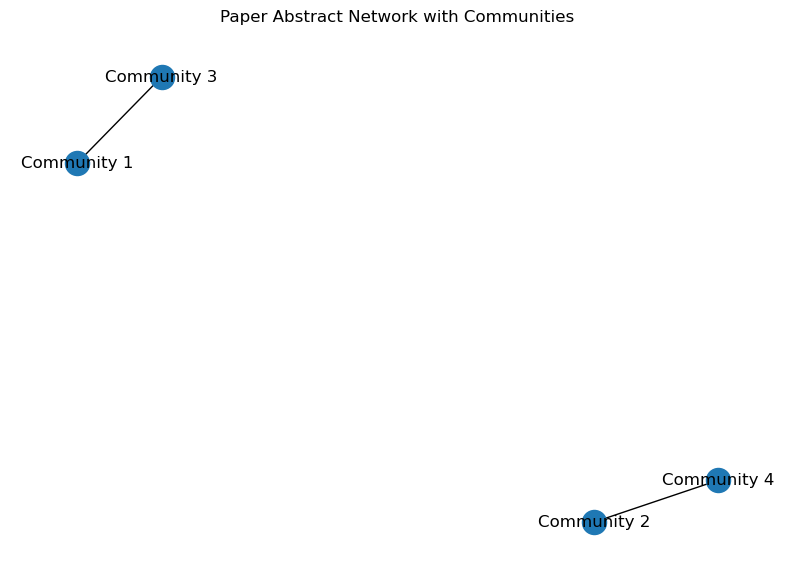

In [54]:
# 데이터 정의
data = {
    'title': [f'Paper{i+1}' for i in range(20)],
    'abstract': [
        'This paper is about AI and machine learning for image recognition.',
        'This paper explores AI and machine learning, specifically neural networks in natural language processing.',
        'This paper focuses on AI applications in healthcare, such as predicting patient outcomes.',
        'This paper delves into AI in healthcare, especially machine learning in medical imaging.',
        'This paper is about the importance of big data in healthcare, using large datasets to improve patient care.',
        'This paper discusses the role of big data in business analytics.',
        'This paper discusses the benefits of cloud computing including cost savings and scalability.',
        'This paper focuses on cloud computing and its application in big data processing.',
        'This paper explores the role of blockchain in finance, specifically in securing transactions.',
        'This paper talks about the importance of blockchain in supply chain management.',
        'This paper investigates the use of AI and machine learning in autonomous vehicles.',
        'This paper talks about AI in robotics, specifically in robotic process automation.',
        'This paper discusses big data in the context of Internet of Things (IoT).',
        'This paper delves into the role of cloud computing in supporting remote work.',
        'This paper focuses on the use of blockchain in creating secure digital identities.',
        'This paper explores the intersection of AI and big data in creating personalized recommendations.',
        'This paper discusses the use of machine learning in detecting credit card fraud.',
        'This paper is about the role of AI in improving customer service, especially through chatbots.',
        'This paper explores the benefits of cloud computing in educational institutions.',
        'This paper discusses the impact of blockchain on the music industry.'
    ]
}

df = pd.DataFrame(data)

# TF-IDF 벡터라이저 생성 (ngram_range 조정)
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# 각 논문을 TF-IDF 벡터로 변환
X = vectorizer.fit_transform(df['abstract'])

# 코사인 유사도를 사용하여 각 논문의 유사성 계산
similarities = cosine_similarity(X)

# 유사성 임계값 설정
similarity_threshold = 0.13

# 각 커뮤니티의 중심점을 찾기
centrality = nx.betweenness_centrality(G)
community_centroids = [max(community, key=lambda x: centrality[x]) for community in communities]

# 커뮤니티 중심점을 기반으로 새 그래프 생성
G_centroids = nx.Graph()

# 중심점 노드 추가
for i, centroid in enumerate(community_centroids):
    G_centroids.add_node(centroid, label=f"Community {i+1}")

# 중심점 간의 유사도 계산
for i in range(len(community_centroids)):
    for j in range(i+1, len(community_centroids)):
        vec_i = vectorizer.transform([df[df['title'] == community_centroids[i]]['abstract'].values[0]])
        vec_j = vectorizer.transform([df[df['title'] == community_centroids[j]]['abstract'].values[0]])
        similarity = cosine_similarity(vec_i, vec_j)[0][0]

        # 유사도가 임계값 이상인 경우만 연결
        if similarity > similarity_threshold:
            G_centroids.add_edge(community_centroids[i], community_centroids[j], weight=similarity)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 7))
node_labels = nx.get_node_attributes(G_centroids, 'label')
nx.draw(G_centroids, labels=node_labels, ax=ax)
plt.title('Paper Abstract Network with Communities')
plt.show()

In [51]:
community_centroids

['Paper6', 'Paper11', 'Paper14', 'Paper15']

In [53]:
for i, community in enumerate(communities):
    print(f"Community {i+1}:")
    for paper in community:
        print(paper)
    print()

Community 1:
Paper5
Paper16
Paper13
Paper12
Paper6
Paper10

Community 2:
Paper1
Paper17
Paper11
Paper2

Community 3:
Paper4
Paper14
Paper7
Paper19

Community 4:
Paper15
Paper20



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx

# 각 논문을 단어 벡터의 평균값으로 표현
document_vectors = []
for abstract in df['abstract']:
    tokens = abstract.split()
    vectors = [word_vectors[word] for word in tokens if word in word_vectors]
    if vectors:
        document_vector = sum(vectors) / len(vectors)
        document_vectors.append(document_vector)
    else:
        # 만약 단어 벡터가 없는 경우, 임의의 벡터를 사용하거나 건너뛸 수 있음
        document_vectors.append(None)

# 코사인 유사도를 사용하여 각 논문의 유사성 계산
similarities = cosine_similarity(document_vectors)

# 유사성 임계값 설정
similarity_threshold = 0.5

# 각 커뮤니티의 중심점을 찾기
centroids = []
for community in communities:
    community_vectors = [document_vectors[df.index.get_loc(title)] for title in community]
    community_centroid = sum(community_vectors) / len(community_vectors)
    centroids.append(community_centroid)

# 그래프 생성
G = nx.Graph()

# 중심점 간의 유사도 계산 및 연결
for i in range(len(centroids)):
    for j in range(i + 1, len(centroids)):
        centroid_i = centroids[i]
        centroid_j = centroids[j]
        similarity = cosine_similarity([centroid_i], [centroid_j])[0][0]
        if similarity > similarity_threshold:
            G.add_edge(f"Centroid {i+1}", f"Centroid {j+1}", weight=similarity)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 7))
nx.draw(G, with_labels=True, ax=ax)
plt.title('Paper Abstract Network with Centroid Similarities')
plt.show()

In [69]:
raw_data = pd.read_csv('./Data/Preprocess_Data/Abstract_preprocessing.csv')

In [74]:
raw_data['Abstract'][0]

"a method for peer to peer streaming of video on demand with residential nodes is described a possible problem with doing peer to peer video on demand streaming is the necessity of storing on the disk of the residential user the content to be streamed allowing a malicious user to distribute illegally the content the proposed method has the advantage of storing on the user's disk only a reduced version of the content although the reduced version stored in disk can still be used in the proposed peer to peer scheme it is not sufficient to recover the original content preventing an unauthorized distribution of it © 2013 ieee"

In [82]:
raw_data['Abstract3'][0]

KeyError: 'Abstract3'

In [83]:
abs3 = pd.read_csv('./Data/Preprocess_Data/Abstract3.csv')

In [84]:
abs3.head()

,Unnamed: 0,Year,Abstract3
0,0,2013,a method for peer_to_peer_streaming of video_o...
1,1,2013,in this paper we discus the bacterial network_...
2,2,2013,this article treat a digital_humanity work in ...
3,3,2013,this work describes preliminary step towards n...
4,4,2013,goal extraction in learning_by_demonstration i...


In [85]:
abs3['Abstract3'][0]

"a method for peer_to_peer_streaming of video_on_demand with residential node is described a possible problem with doing peer_to_peer video_on_demand streaming is the necessity of storing on the disk of the residential user the content to be streamed allowing a malicious_user to distribute illegally the content the proposed method ha the advantage of storing on the user's disk only a reduced version of the content although the reduced version stored in disk can still be used in the proposed peer_to_peer scheme it is not sufficient to recover the original content preventing an unauthorized distribution of it © 2013 ieee"